<center>
    <b>RNAge Progress Report</b>
    <br>
    <a href="https://github.com/edgeslab/cs418-project-RNAge/blob/master/Progress_Report.ipynb">
        https://github.com/edgeslab/cs418-project-RNAge/blob/master/Progress_Report.ipynb
    </a>
</center>

In [10]:
#Import necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML,Image
from pathlib import Path
import sklearn
import sklearn.model_selection
import sklearn.feature_selection
from os import listdir
%matplotlib inline

In [11]:
#Setting up the environment and importing the necessary data

sns.set_style("darkgrid")
data_dir=Path("data")
tissue_dir=Path("tissue-specific")

#!mkdir data && cp merged_meta.tsv data #Needed after cloning repo
manifest={
    "data":"All_Tissue_Site_Details.combined.reads.gct",
    "sample_meta":"GTEx_v7_Annotations_SampleAttributesDS.txt",
    "subject_meta":"GTEx_v7_Annotations_SubjectPhenotypesDS.txt",
    "merged_meta":"merged_meta.tsv"}

meta=pd.read_csv(manifest['merged_meta'],sep="\t",dtype={'SMUBRID':object,'SEX':object,'DTHHRDY':object})

## Introduction

The aim of the project is to:
<ol>
    <li>Characterize and compare the relationship of different tissues with aging.</li>
    <li>Find significant genes participating in aging across different tissues.</li>
</ol>
Additional goal is to:
<ul>
    <li>Find the differences in aging in healthy and diseased tissues.</li>
</ul>

## Data acquisition

<b>Data source:</b>
<br>
The data has been obtained from GTEx portal.
<br><br>
<u>Data source:</u> https://gtexportal.org/home/datasets
<br>
<u>Data summary:</u> https://gtexportal.org/home/tissueSummaryPage
<br><br>
This data can be downloaded and placed under 'data' directory.
<br><br>
<b>Data Pre-processing:</b>
<br>
Due to the huge size of the original file, it is split into tissue specific data files for easier processing on local machines.

## Changes

The objective presented at the initial checkin has been retained. Albeit, the results of the mid-phase report could influence the feasibility of achieving the final goals.

## Data Cleaning

Our *Data Cleaning* has four general steps.
<ol>
    <li>Remove samples without age.</li>
    <li>Choose tissues with counts more than 200.</li>
    <li>Filter samples with low varuance and low expression level.</li>
    <li>Remove samples with low row counts.</li>
</ol>



Our data has some missing *age* information. When we upload CSV files for each tissue, we eliminate all samples with missed age. The following piece of code removes samples without age.

In [14]:
meta=meta[~(meta['AGE'].isnull())] # removes all samples without age



We choose the tissues which are relatively large enough. We assume that if the count number of a tissue is more that 200, we can include that in our analysis, otherwise, we eliminate the tissue.

In [15]:
counts=pd.DataFrame(meta['SMTS'].value_counts())
display(counts)

,SMTS
Skin,1202
Esophagus,1021
Blood Vessel,913
Adipose Tissue,797
Heart,600
Muscle,564
Blood,537
Colon,507
Thyroid,446
Lung,427


This table shows that there are many tissues with >200 samples with age recorded. Only tissues with 200 samples or more will be considered for predictive analysis.

In [5]:
df=meta[meta['SMTS'].isin(counts[counts['SMTS']>200].index)]
df=pd.crosstab(index=df['SMTS'],columns=df['AGE'])
display(df)

AGE,20-29,30-39,40-49,50-59,60-69,70-79
SMTS,,,,,,
Adipose Tissue,57,66,131,273,245,25
Blood,50,46,103,169,163,6
Blood Vessel,75,75,160,310,273,20
Brain,12,8,36,112,152,11
Breast,26,32,53,88,81,10
Colon,45,48,95,164,140,15
Esophagus,102,91,191,356,258,23
Heart,33,29,95,220,205,18
Lung,27,30,76,145,139,10


Now, all our data includes age of the sample and tissue with more than 200 counts.

In [6]:
TISSUE='Colon'
infiles=listdir(data_dir/tissue_dir)
TISSUE_files=[f for f in infiles if  TISSUE in f]
TISSUE_files

cpm=pd.read_csv(data_dir/tissue_dir/str(TISSUE+"_cpm.tsv"),sep="\t",index_col=0)
lcpm=pd.read_csv(data_dir/tissue_dir/str(TISSUE+"_lcpm.tsv"),sep="\t",index_col=0)
cdat=pd.read_csv(data_dir/tissue_dir/str(TISSUE+"_c.tsv"),sep="\t",index_col=0)

In [7]:
lib_size=np.sum(cdat,axis=1)
#plt.figure(figsize=(16, 6))
#sns.distplot(lib_size,kde=False,rug=True)
#cpm.iloc[0:5,0:6]

We now filter data by expression level with the following function

In [8]:
# Likely not possible in Python as cpm() is required
def filter_by_expr(counts,min_count=None,min_sample=None,grp=None):
    lib_size=np.sum(counts,axis=1)
    MedianLibSize=np.median(lib_size)
    norm_cutoff=min_count/MedianLibSize*1e6
    print(norm_cutoff)
    gene_counts=np.sum(counts)

At the next step, we filter by row count threshold 

In [9]:
tissue_meta=meta[(meta['SMTS']==TISSUE)]
tissue_meta.iloc[0:3]

cdat_train, cdat_test, y_train, y_test = \
        sklearn.model_selection.train_test_split(cdat, tissue_meta['AGE'], test_size=.3, random_state=1234)
cpm_train, cpm_test, y_train, y_test = \
        sklearn.model_selection.train_test_split(cpm, tissue_meta['AGE'], test_size=.3, random_state=1234) # random state guarantees that the same split is made for a given tissue.
print(cpm_train.shape)
print(cpm_test.shape)
print(y_train.shape)
print(y_test.shape)
#GTEX-P78B-1326-SM-3P611 for reference for liver
print(cdat_train.index[0])
print(cpm_train.index[0]) # Confirms that two different calls to train_test_split on a different data set produce the same results
sum(cpm_train.iloc[:,0]) # Confirms that the split is the same each time
# Biased against samples with a smaller library size
def simpleExpressionFilter(counts,min_count):
    """accepts raw counts and a minimum sum count per gene across all samples
    return a boolean array of all genes, which can be applied to any transformed counts.
    True is associated with passing the test.
    """
    keep=np.sum(counts)>min_count
    print("Pre",counts.shape[1])
    filtered_counts=counts.loc[:,(keep)] # similar to how the boolean array would be used on any count matrix
    print("Post",filtered_counts.shape[1])
    return(keep)
keep_expr=simpleExpressionFilter(cdat_train,10)
cpm_train_expression_filter=cpm_train.loc[:,(keep_expr)]
cpm_test_expression_filter=cpm_test.loc[:,(keep_expr)]
print(cpm_test_expression_filter.shape) # confirming that both train and test set have undergone transformation identically
print(cpm_train_expression_filter.shape)

(354, 56202)
(153, 56202)
(354,)
(153,)
GTEX-14PHX-1126-SM-5YYA5
GTEX-14PHX-1126-SM-5YYA5
Pre 56202
Post 44995
(153, 44995)
(354, 44995)


Finally, we can filter by low variance variance and plot mean distribution of genes after each step explained above.

In [10]:
selector=sklearn.feature_selection.VarianceThreshold(threshold=.1)
selector.fit(cpm_train_expression_filter)
var_keep=selector.get_support(indices=True)
train_final=cpm_train_expression_filter.iloc[:,var_keep]
test_final=cpm_test_expression_filter.iloc[:,var_keep]
print("Pre",cpm_train_expression_filter.shape[1])
print("Post",train_final.shape[1])

print(train_final.shape) # confirming that both train and test set have undergone transformation identically
print(test_final.shape)

Pre 44995
Post 18572
(354, 18572)
(153, 18572)


/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.
/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


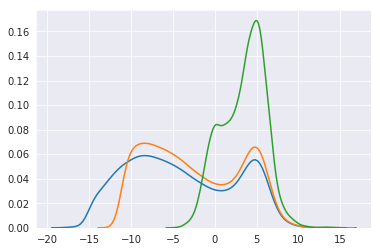

In [11]:
ax=sns.kdeplot(np.log2(np.mean(cpm_train,axis=0)))
ax=sns.kdeplot(np.log2(np.mean(cpm_train_expression_filter,axis=0)))
ax=sns.kdeplot(np.log2(np.mean(train_final,axis=0)))

## EDA

The objective of our EDA efforts were to explore each useful metadata field. The useful features included:
- Tissue origin (SMTS)
- Tissue sub-origin (SMTSD)
- Sex (SEX)
- Age (AGE)
- Death Classification Hardy Scale (DTHHRDY)

Our first task was to understand how many samples were from each tissue origin. This table shows how many samples are from each tissue. Interestingly, some of the lowest count tissues are sex organs. Some of the most collected tissues seem that they may have been easier to collect.

In [18]:
meta=pd.read_csv(data_dir/manifest['merged_meta'],sep="\t",dtype={'SMUBRID':object,'SEX':object,'DTHHRDY':object})
counts=pd.DataFrame(meta['SMTS'].value_counts())
display(counts)

,SMTS
Brain,1671
Skin,1203
Esophagus,1021
Blood Vessel,913
Adipose Tissue,797
Heart,600
Muscle,564
Blood,537
Colon,507
Thyroid,446


### Sub-tissue location
We then sought to explore how SMTSD,sub-tissue location, affects the samples. We generated PCA plots using the top 500 most variable genes following the logCPM transformation. The code for these plots can be found in `GTEx_input.R`. We found that SMTSD seems to account for the largest axis of variance for any tissue where STMSD is recorded. Representative plots from the blood and brain samples are shown.
![](progress_plots/Blood_Vessel_SMTSD_PCA.png)
![](progress_plots/Brain_SMTSD_PCA.png)

### Age
We then explored age, the primary dependent variable in our project. We found that many subjects did not have age recorded, affecting nearly 1500 samples.

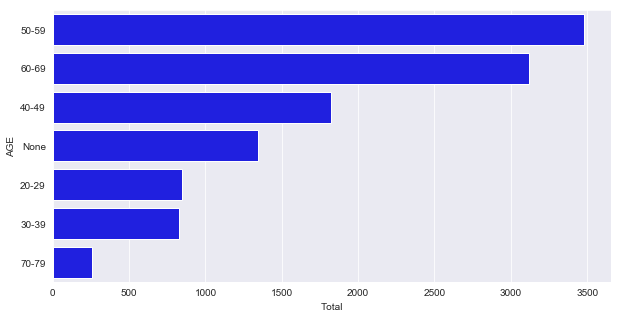

In [5]:
sns.set_color_codes("pastel")
AGE=meta['AGE'].copy()
AGE[AGE.isnull()]="None"
counts=pd.DataFrame({"AGE":AGE.value_counts()})
counts['Total']=counts['AGE']
counts['AGE']=counts.index.values
plt.figure(figsize=(10, 5))
ax=sns.barplot(x="Total", y="AGE", data=counts, label="Total", color="blue")

### Gender
We explored the gender feature (SEX) in the same way. We found that there are many more men than women in the data set. And again, there are nearly 1500 samples with sex recorded.

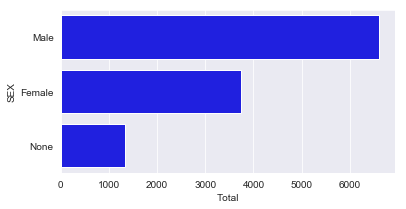

In [12]:
sns.set_color_codes("pastel")
SEX=meta['SEX'].copy()
SEX[SEX.isnull()]="None"
counts=pd.DataFrame({"SEX":SEX.value_counts()})
counts['Total']=counts['SEX']
counts['SEX']=counts.index.values
counts['SEX'].replace({"1.0":"Male","2.0":"Female"},inplace=True)
plt.figure(figsize=(6, 3))
ax=sns.barplot(x="Total", y="SEX", data=counts, label="Total", color="blue")

### Library size
We found that library sizes (the total number of reads sequenced and aligned into counts) were generally around 10 million, which is good, but there are some outliers for each tissue. This plot shows the distribution of library sizes for Colon samples. Code for this plot can be viewed in `perTissue_models.ipynb`.
![](progress_plots/libsizeplot.png)

### Death classification
And finally we visualized the effect of the death classification with MDS plots from `Glimma` a specialized R package which utilizes `D3.js` to visualize RNA-seq data. We created MDS plots for every tissue, but the heart is particularly representative of the trends from the metadata features. The plot below can browsed interactively **[here](progress_plots/Heart/MDS-Plot.html)**.

A selected view shows that death classification has a major effect in the second and third dimension of MDS. There appears to be major differences between samples that died by vent or quickly by natural causes. This makes intuitive sense because dying while on a vent involves hypoxia. This trend persists for most tissues.
![](progress_plots/MDS.png)

## Visualization

We knew that some tissues had very few samples. To begin testing the relationships of the data, we needed to establish a threshold of minimum number of samples per tissue. This table shows the number of people in each age group.

In [16]:
counts=pd.DataFrame(meta['SMTS'].value_counts())
df=meta[meta['SMTS'].isin(counts[counts['SMTS']>1].index)]
df=pd.crosstab(index=df['SMTS'],columns=df['AGE'])
sorted_i=df.sum(axis=1).sort_values(ascending=False).index.values
df=df.loc[sorted_i,:]
display(df)

AGE,20-29,30-39,40-49,50-59,60-69,70-79
SMTS,,,,,,
Skin,98,94,200,398,377,35
Esophagus,102,91,191,356,258,23
Blood Vessel,75,75,160,310,273,20
Adipose Tissue,57,66,131,273,245,25
Heart,33,29,95,220,205,18
Muscle,46,45,88,188,179,18
Blood,50,46,103,169,163,6
Colon,45,48,95,164,140,15
Thyroid,30,29,81,151,143,12


C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


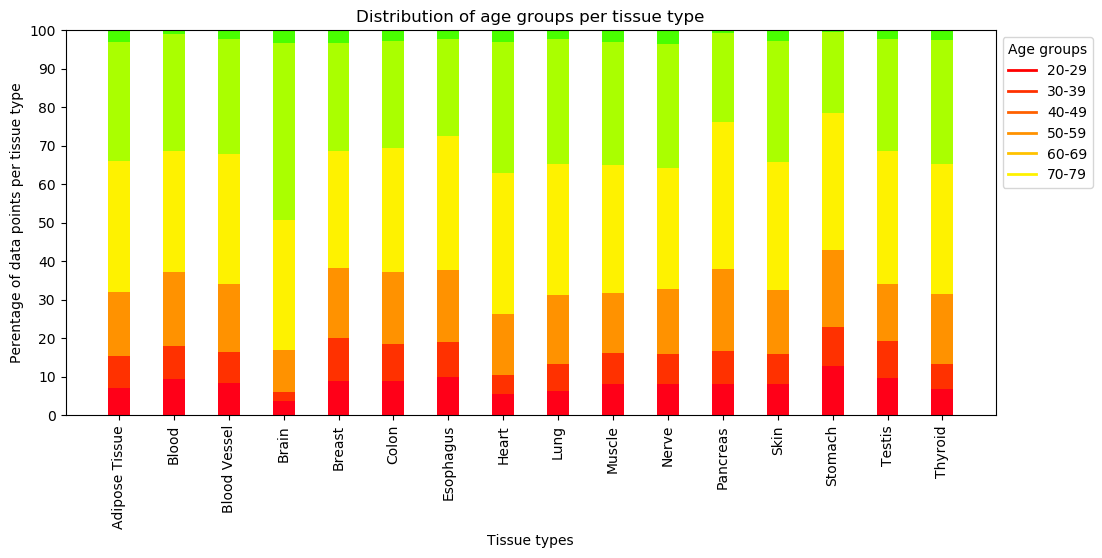

In [17]:
import matplotlib as mpl
from matplotlib.lines import Line2D
    
df2=meta[meta['SMTS'].isin(counts[counts['SMTS']>200].index)]
df2_cols = df2.columns.values
df2_cols[0] = 'row_id'
df2.columns = df2_cols
grp_trends = df2[['SMTS', 'AGE', 'row_id']].groupby(['SMTS', 'AGE']).count().reset_index()
grp_trends['percentage_per_tissue'] = 1.0
for index, row in grp_trends.iterrows():
    grp_trends.at[index, 'percentage_per_tissue'] = (row['row_id'] / grp_trends['row_id'][grp_trends['SMTS']==row['SMTS']].sum()) * 100

unique_age = grp_trends['AGE'].unique()
unique_tissue = grp_trends['SMTS'].unique()

percent_matrix = np.zeros(shape=(len(unique_age), len(unique_tissue)))

i = 0
for entry in unique_age:
    percent_matrix[i] = (grp_trends['percentage_per_tissue'][grp_trends['AGE']==entry]).as_matrix()
    i += 1

cmap = mpl.cm.get_cmap('hsv', len(unique_tissue)*2)
colorPalette = []
for i in range(cmap.N):
    rgb = cmap(i)[:3] #returns [rgba], hence extracting [rgb]
    colorPalette.append(mpl.colors.rgb2hex(rgb))

mpl.style.use('default')
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)

configs = percent_matrix[0]
N = len(configs)
ind = np.arange(N)
width = 0.4

i = 0
plt.bar(ind, percent_matrix[i], width, color=colorPalette[i*2-1])
i += 1
while i < len(unique_age):
    j = i-1
    res = np.zeros(shape=(1, len(unique_tissue)))
    while j >= 0:
        res += percent_matrix[j]
        j -= 1
    plt.bar(ind, percent_matrix[i], width, bottom=res[0], color=colorPalette[i*2-1], tick_label='placeholder')
    i += 1
    
ax.set_xticklabels(unique_tissue, rotation=90)
ax.set(title='Distribution of age groups per tissue type')
ax.set(xlabel='Tissue types')
ax.set(ylabel='Perentage of data points per tissue type')
ax.set(ylim=(0,100))
ax.set(yticks=np.arange(0,110,10))

leg_ele = [
    Line2D([0], [0], lw=2, color=colorPalette[0], label=unique_age[0]),
    Line2D([0], [0], lw=2, color=colorPalette[1], label=unique_age[1]),
    Line2D([0], [0], lw=2, color=colorPalette[2], label=unique_age[2]),
    Line2D([0], [0], lw=2, color=colorPalette[3], label=unique_age[3]),
    Line2D([0], [0], lw=2, color=colorPalette[4], label=unique_age[4]),
    Line2D([0], [0], lw=2, color=colorPalette[5], label=unique_age[5])
    ]
ax.legend(handles = leg_ele, loc='upper left', bbox_to_anchor=(1,1), title='Age groups')
       
plt.show()

<i>Observations:</i>
<ul>
    <li>It can be observed that the age group distribution is not uniform.</li>
    <li>The general trend seems to for the age range '70-79' to have very less or no data points at all.</li>
    <li>This has to be accounted for in the ML/DL models built: oversampling/undersampling may be performed if required.</li>
</ul>

### Differential Gene Expression
We also wanted to test whether there was differential gene expression (DGE) on the basis of subject age for any tissue. This was done for all tissues, but the results from the Pancreas will be seen here.

Specifically, we tested $LA vs. HA = \frac{(A1+A2+A3)}{3}-\frac{(A4+A5+A6)}{3}$ where LA means low-age and HA means high age, and where our null hypothesis for each gene was there is no difference in the gene expression between the two populations.

Unfortunately, there are no tools in Python to accomplish the mean-dispersion estimation/transformation needed to run statistical tests on RNA-seq count data. Instead, we used `R` and the `edgeR`, `Limma`, and `Glimma` packages. The code to run DGE can be found in `GTEx_DGE_AGE.R`.
The edgeR → Limma pipeline is unique insofar that it transforms the right-skewed and heteroskedastic count data into a normal distribution for traditional linear methods. 

This process is called voom and can be seen in the following two plots, one from before and after the transformation.
![](progress_plots/Pancreas/Init_SA.png)
![](progress_plots/Pancreas/Final_SA.png)

The high dispersion outliers are generally sexually dimorphic genes. This trend occurs to some degree for most tissues. This impacted the normalization and DGE process and indicates it may be a good idea to only work with male samples.

### [DGE Results](progress_plots/Pancreas/MD-Plot.html) - Pancreas

Differential expression analysis in edgeR and Limma involves fitting a linear model to the normalized data to better estimate the dispersion of each gene. This pooled dispersion is then used in the computation of a *moderated* t-statistic between the test groups

In general, we did not detect differential expression when the lowest three age groups were compared with the highest three age groups. Many genes were marginally differentially expressed, but the BH multiple hypothesis testing correction meant that very few genes were statistically significantly differentially expressed. 

Below is a snapshot of the MD plot, which plots mean expression vs. log-fold change between the groups. Usually, differentially expressed genes are highlighted in color, but there are none in this case. This interactive plot can be viewed [here](progress_plots/Pancreas/MD-Plot.html).
![](progress_plots/MD.png)

Visually, there were trends in some genes the seemed to reflect a trend based on age. A strip chart for one such gene can be seen below. For each tissue, there were a handful of anecdotally significant genes with functions relevant to the tissue. For example, the pancreas is a major extracellular exporter, and this gene which appears to be differentially expressed has to do with the Golgi apparatus.
![](progress_plots/MD_full.png)

## ML

We use the <b>PyTorch</b> classifier to build the model and predict the age groups for different tissues. It is a deep learning research platform that provides maximum flexibility and speed.</n>
PyTorch provides two main features:</n>
- An n-dimesnional tensor
- Automatic differentiation for building and training neural networks

We build a simple model with all the attributes for the genes as inputs and six output layers(one for each age group).

#### Baseline classifier

We consider the majority classifier for each tissue type to be the baseline classifier in order to compare the performance of the constructed model.

In [22]:
maj_clf = grp_trends[['percentage_per_tissue', 'SMTS']].groupby(['SMTS']).max().reset_index()
maj_clf

,SMTS,percentage_per_tissue
0,Adipose Tissue,34.253450
1,Blood,31.471136
2,Blood Vessel,33.953998
3,Brain,45.921450
4,Breast,30.344828
5,Colon,32.347140
6,Esophagus,34.867777
7,Heart,36.666667
8,Lung,33.957845
9,Muscle,33.333333


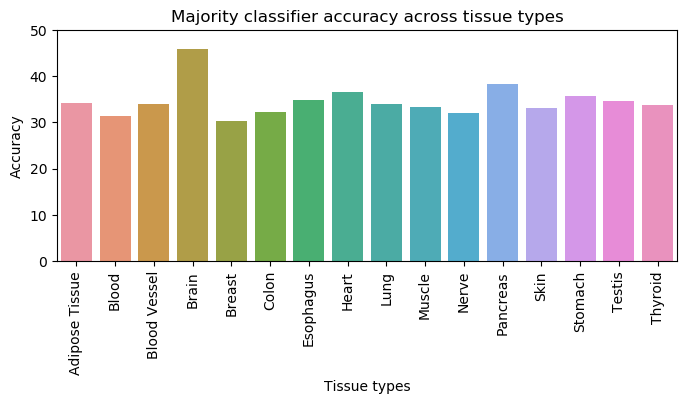

In [32]:
import warnings
warnings.filterwarnings('ignore')

mpl.style.use('default')
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)

model_plot = sns.barplot(x = maj_clf['SMTS'],
            y=maj_clf['percentage_per_tissue'],
            data = maj_clf,
            orient='v',
            estimator=np.mean,
            capsize=0.1)

tick_labels = maj_clf['SMTS'].as_matrix()
ax.set_xticklabels(tick_labels,rotation=90)
ax.set(ylim=(0,50))
ax.set(title='Majority classifier accuracy across tissue types')
ax.set(xlabel='Tissue types')
ax.set(ylabel='Accuracy')

plt.show()

In [1]:
import pandas as pd
from pathlib import Path
from os import listdir
import sklearn.model_selection
import sklearn.feature_selection
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data

data_dir=Path("data")
tissue_dir=Path("tissue-specific")
manifest={"data":"All_Tissue_Site_Details.combined.reads.gct",
              "sample_meta":"GTEx_v7_Annotations_SampleAttributesDS.txt",
              "subject_meta":"GTEx_v7_Annotations_SubjectPhenotypesDS.txt",
               "merged_meta":"merged_meta.tsv"}
meta=pd.read_csv(data_dir/manifest['merged_meta'],sep="\t",dtype={'SMUBRID':object,'SEX':object,'DTHHRDY':object})
meta=meta[~(meta['AGE'].isnull())] # removes all samples without age
#meta=meta[~(np.isnan(meta['AGE']))]
#meta.iloc[0:3,:]
counts=pd.DataFrame(meta['SMTS'].value_counts())
df=meta[meta['SMTS'].isin(counts[counts['SMTS']>200].index)]
df=pd.crosstab(index=df['SMTS'],columns=df['AGE'])
tissues = df.index.values
print(tissues)

['Adipose Tissue' 'Blood' 'Blood Vessel' 'Brain' 'Breast' 'Colon'
 'Esophagus' 'Heart' 'Lung' 'Muscle' 'Nerve' 'Pancreas' 'Skin' 'Stomach'
 'Testis' 'Thyroid']


In [2]:
class my_points():
    def __init__(self):
        self.data = cpm_new 
        self.target = y_train_new.as_matrix() 
        self.n_samples = self.data.shape[0]
    
    def __len__(self):   
        return self.n_samples
    
    def __getitem__(self, index):
        return self.data[index], self.target[index]

In [3]:
# We build a simple model with the inputs and six output layers(one for each age group).
class my_model(nn.Module):
    def __init__(self,n_in=56201,n_hidden=10,n_out=6):
        super(my_model,self).__init__()
        self.n_in  = n_in
        self.n_out = n_out
         
        self.linearlinear = nn.Sequential(
            nn.Linear(self.n_in,self.n_out,bias=True),   # Hidden layer.
            )
        self.logprob = nn.LogSoftmax(dim=1)                 # -Log(Softmax probability).
    
    def forward(self,x):
        x = self.linearlinear(x)
        x = self.logprob(x)
        return x

In [4]:
infiles=listdir(data_dir/tissue_dir)
tissueList = tissues
accuracies=[]
ts=[]
for TISSUE in tissueList:
    print(TISSUE)
    TISSUE_files=[f for f in infiles if  TISSUE in f]
    cpm=pd.read_csv(data_dir/tissue_dir/TISSUE_files[1],sep="\t",index_col=0)
    lcpm=pd.read_csv(data_dir/tissue_dir/TISSUE_files[0],sep="\t",index_col=0)
    tissue_meta=meta[meta['SMTS']==TISSUE]
    print('Dimensions: ',lcpm.shape)
    if tissue_meta.shape[0] == lcpm.shape[0]:
        
        cpm_train, cpm_test, y_train, y_test = \
                sklearn.model_selection.train_test_split(cpm, tissue_meta['AGE'], test_size=.3, random_state=1234) 
        # random state guarantees that the same split is made for a given tissue.
        cpm_new = cpm_train.as_matrix()
        cpm_new = np.delete(cpm_new,0,axis=1)
        y_train_new = y_train.map({'20-29':0,'30-39':1,'40-49':2,'50-59':3, '60-69':4, '70-79':5})
        my_data = my_points()
        batch_size = 1
        import torch.utils.data as data
        my_loader = data.DataLoader(my_data,batch_size=batch_size,num_workers=0)
        # Now, we create the mode, the loss function or criterium and the optimizer 
        # that we are going to use to minimize the loss.

        # Model.
        model = my_model()

        # Negative log likelihood loss.
        criterium = nn.NLLLoss()

        # Adam optimizer with learning rate 0.1 and L2 regularization with weight 1e-4.
        optimizer = torch.optim.Adam(model.parameters(),lr=0.1,weight_decay=1e-4)
        # Training.
        model.double()
        accuracy=0
        for epoch in range(3):
            truecount=0
            totalcount=0

            for k, (data, target) in enumerate(my_loader):
                model.zero_grad()
                log_p = model(data)
                loss = criterium(log_p,target)
                loss.backward()
                totalcount+=1
                if(target == torch.max(torch.exp(log_p),1)[1]):
                    truecount+=1
                # Model weight modification based on the optimizer. 
                optimizer.step()
            if ((truecount/totalcount)*100)>accuracy:
                accuracy = (truecount/totalcount)*100
                accuracies.append(accuracy)
                ts.append(TISSUE)
            print('Epoch ',epoch+1,':',truecount/totalcount)

        print('Accuracy for ',TISSUE,' tissue: ',accuracy)

Adipose Tissue
Dimensions:  (797, 56202)


C:\Users\adity\Anaconda3\envs\cs418env\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\adity\Anaconda3\envs\cs418env\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Epoch  1 : 0.2980251346499102
Epoch  2 : 0.3123877917414722
Epoch  3 : 0.36624775583482944
Accuracy for  Adipose Tissue  tissue:  36.62477558348294
Blood
Dimensions:  (913, 56202)
Blood Vessel
Dimensions:  (913, 56202)
Epoch  1 : 0.24569640062597808
Epoch  2 : 0.3411580594679186
Epoch  3 : 0.39593114241001565
Accuracy for  Blood Vessel  tissue:  39.593114241001565
Brain
Dimensions:  (331, 56202)
Epoch  1 : 0.3852813852813853
Epoch  2 : 0.329004329004329
Epoch  3 : 0.3939393939393939
Accuracy for  Brain  tissue:  39.39393939393939
Breast
Dimensions:  (290, 56202)
Epoch  1 : 0.23645320197044334
Epoch  2 : 0.2561576354679803
Epoch  3 : 0.2857142857142857
Accuracy for  Breast  tissue:  28.57142857142857
Colon
Dimensions:  (507, 56202)
Epoch  1 : 0.2824858757062147
Epoch  2 : 0.3050847457627119
Epoch  3 : 0.3361581920903955
Accuracy for  Colon  tissue:  33.61581920903955
Esophagus
Dimensions:  (1021, 56202)
Epoch  1 : 0.27450980392156865
Epoch  2 : 0.32072829131652664
Epoch  3 : 0.366946778

C:\Users\adity\Anaconda3\envs\cs418env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0, 0.5, 'Accuracy')]

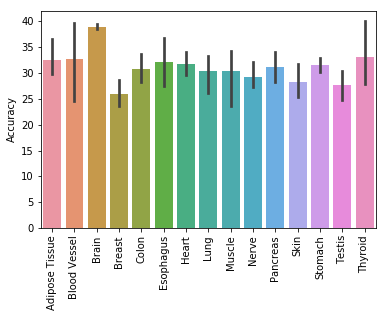

In [5]:
import seaborn as sns
ax = sns.barplot(x=ts,y=accuracies)
for item in ax.get_xticklabels():
    item.set_rotation(90)
ax.set(ylabel='Accuracy')

## Reflection

- The size of the data has been extremely prohibitive. The transformed counts are floats, which take much more space. It is best to compute the cpm transformation on the entire data set, meaning that we had to create these floats all in R before moving to Python.
- It can be observed that the DL model is not producing satisfactory results. It seems to enhance the argument that identifying there doesn't seem to be one predominant gene to predict the age.

## Next Steps

- The immediate takeaway is to improve the performance of the available models to achieve satisfactory results.
- Identify effective transformations of the gene expression data, if possible.